In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from fr_utils import *
from inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'keras'

In [2]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [3]:
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    
    return loss

In [5]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [6]:
database = {}

database["abhinav"] = img_to_encoding("images/abhinav.jpeg", FRmodel)
database["saksham"] = img_to_encoding("images/saksham.jpeg", FRmodel)
database["prashant"] = img_to_encoding("images/prashant.jpeg", FRmodel)
database["Mr. Ashish Ranjan Mishra"] = img_to_encoding("images/ARM.jpg", FRmodel)
database["shashank"] = img_to_encoding("images/shashank.jpeg", FRmodel)


In [7]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    same_person -- True, if the person is same as. False otherwise.
    """
    
    # Step 1: Compute the encoding for the image. Use img_to_encoding()
    encoding = img_to_encoding(image_path,model)
    
    # Step 2: Compute distance with identity's image
    dist = np.linalg.norm(encoding - database[identity])
    
    # Step 3: Welcome if dist < 0.8, else go away
    if dist<0.8:
        print("It's " + str(identity) + ", welcome!")
        same_person = True
    else:
        print("It's not " + str(identity) + ", please go away")
        same_person = False
            
    return dist, same_person

It's abhinav, welcome!


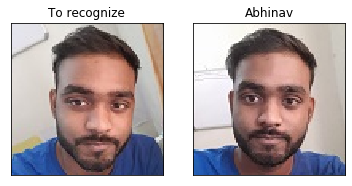

In [8]:
dist,isSame = verify("images/camera_1.jpeg", "abhinav", database, FRmodel)

img = cv2.imread('images/camera_1.jpeg',1)
img = img[...,::-1]
plt.subplot(1,2,1)
plt.title('To recognize')
plt.imshow(img)
plt.xticks([]), plt.yticks([])
img = cv2.imread('images/abhinav.jpeg',1)
img = img[...,::-1]
plt.subplot(1,2,2)
plt.title('Abhinav')
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

It's not prashant, please go away


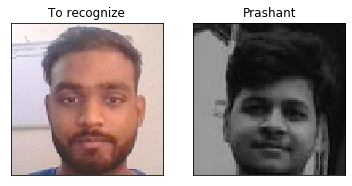

0.9080714

In [9]:
dist,isSame = verify("images/camera_2.jpg", "prashant", database, FRmodel)

img = cv2.imread('images/camera_2.jpg',1)
img = img[...,::-1]
plt.subplot(1,2,1)
plt.title('To recognize')
plt.imshow(img)
plt.xticks([]), plt.yticks([])
img = cv2.imread('images/prashant.jpeg',1)
img = img[...,::-1]
plt.subplot(1,2,2)
plt.title('Prashant')
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

dist

It's Mr. Ashish Ranjan Mishra, welcome!


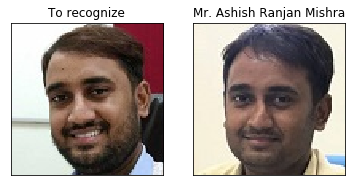

0.75705034

In [10]:
dist,isSame = verify("images/ARMMM.jpg", "Mr. Ashish Ranjan Mishra", database, FRmodel)

img = cv2.imread('images/ARMMM.jpg',1)
img = img[...,::-1]
plt.subplot(1,2,1)
plt.title('To recognize')
plt.imshow(img)
plt.xticks([]), plt.yticks([])
img = cv2.imread('images/ARM.jpg',1)
img = img[...,::-1]
plt.subplot(1,2,2)
plt.title('Mr. Ashish Ranjan Mishra')
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

dist

In [11]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
    ##Compute the target "encoding" for the image. Using img_to_encoding()
    encoding = img_to_encoding(image_path,model)
    
    ##Find the closest encoding ##
    
    # Initialize "min_dist" to a large value
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database.
        dist = np.linalg.norm(encoding-db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
        if dist<min_dist:
            min_dist = dist
            identity = name

    
    if min_dist > 0.85:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

it's abhinav, the distance is 0.4919486


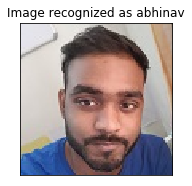

In [12]:
img_path = "images/camera_1.jpeg"
dist,name = who_is_it(img_path, database, FRmodel)

img = cv2.imread(img_path,-1)
img = img[...,::-1]
plt.subplot(1,2,1)
plt.title('Image recognized as '+name)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

it's abhinav, the distance is 0.6612043


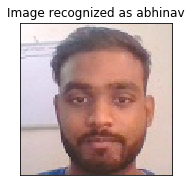

In [13]:
img_path = "images/camera_2.jpg"
dist,name = who_is_it(img_path, database, FRmodel)

img = cv2.imread(img_path,-1)
img = img[...,::-1]
plt.subplot(1,2,1)
plt.title('Image recognized as '+name)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

it's abhinav, the distance is 0.67972535


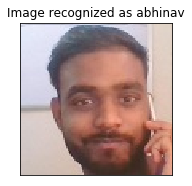

In [14]:
img_path = "images/camera_3.jpg"
dist,name = who_is_it(img_path, database, FRmodel)

img = cv2.imread(img_path,-1)
img = img[...,::-1]
plt.subplot(1,2,1)
plt.title('Image recognized as '+name)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

it's saksham, the distance is 0.5792175


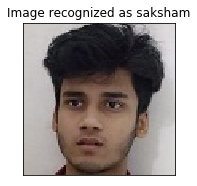

In [15]:
img_path = "images/camera_4.jpeg"
dist,name = who_is_it(img_path, database, FRmodel)

img = cv2.imread(img_path,-1)
img = img[...,::-1]
plt.subplot(1,2,1)
plt.title('Image recognized as '+name)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

it's prashant, the distance is 0.6650264


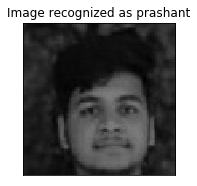

In [16]:
img_path = "images/camera_5.jpeg"
dist,name = who_is_it(img_path, database, FRmodel)

img = cv2.imread(img_path,-1)
img = img[...,::-1]
plt.subplot(1,2,1)
plt.title('Image recognized as '+name)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()

it's Mr. Ashish Ranjan Mishra, the distance is 0.75705034


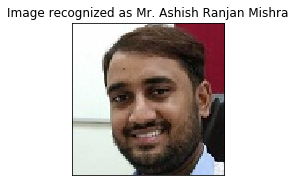

In [17]:
img_path = "images/ARMMM.jpg"
dist,name = who_is_it(img_path, database, FRmodel)

img = cv2.imread(img_path,-1)
img = img[...,::-1]
plt.subplot(1,2,1)
plt.title('Image recognized as '+name)
plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.show()